In [6]:
!pip install xgboost
import os #paths to file
import numpy as np # linear algebra
import pandas as pd # data processing
import warnings# warning filter


#ploting libraries
import matplotlib.pyplot as plt 
import seaborn as sns


In [7]:

#relevant ML libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

#ML models
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#default theme
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)

#warning hadle
warnings.filterwarnings("ignore")

C:\Users\LENOVO PC\anaconda3\envs\loan_prediction\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [11]:
#list all files under the input directory
for dirname, _, filenames in os.walk('../data/raw/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


../data/raw/.gitkeep
../data/raw/tran.csv


In [14]:
#path for the training set
tr_path = "../data/raw/tran.csv"
#path for the testing set
te_path = "../data/raw/test.csv"


In [13]:
# read in csv file as a DataFrame
tr_df = pd.read_csv(tr_path)
# explore the first 5 rows
tr_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
1,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
2,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
3,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N
4,LP001024,Male,Yes,2,Graduate,No,3200,700.0,70.0,360.0,1.0,Urban,Y


In [15]:
# read in csv file as a DataFrame
te_df = pd.read_csv(te_path)
# explore the first 5 rows
te_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [16]:
#column information
tr_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608 entries, 0 to 607
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            608 non-null    object 
 1   Gender             595 non-null    object 
 2   Married            605 non-null    object 
 3   Dependents         593 non-null    object 
 4   Education          608 non-null    object 
 5   Self_Employed      576 non-null    object 
 6   ApplicantIncome    608 non-null    int64  
 7   CoapplicantIncome  608 non-null    float64
 8   LoanAmount         587 non-null    float64
 9   Loan_Amount_Term   594 non-null    float64
 10  Credit_History     558 non-null    float64
 11  Property_Area      608 non-null    object 
 12  Loan_Status        608 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 61.9+ KB


In [17]:
#summary statistics
tr_df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,608.000000,608.000000,587.000000,594.000000,558.000000
mean,5411.664474,1623.985066,146.429302,341.818182,0.840502
std,6137.147394,2936.449606,85.732279,65.423724,0.366469
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2875.750000,0.000000,100.000000,360.000000,1.000000
50%,3806.000000,1188.500000,128.000000,360.000000,1.000000
75%,5785.000000,2287.750000,168.000000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


In [18]:
#the Id column is not needed, let's drop it for both test and train datasets
tr_df.drop('Loan_ID',axis=1,inplace=True)
te_df.drop('Loan_ID',axis=1,inplace=True)
#checking the new shapes
print(f"training set (row, col): {tr_df.shape}\n\ntesting set (row, col): {te_df.shape}")

training set (row, col): (608, 12)

testing set (row, col): (367, 11)


In [19]:
tr_df.isnull().sum().sort_values(ascending=False)

Credit_History       50
Self_Employed        32
LoanAmount           21
Dependents           15
Loan_Amount_Term     14
Gender               13
Married               3
Education             0
ApplicantIncome       0
CoapplicantIncome     0
Property_Area         0
Loan_Status           0
dtype: int64

In [20]:
#filling the missing data
print("Before filling missing values\n\n","#"*50,"\n")
null_cols = ['Credit_History', 'Self_Employed', 'LoanAmount','Dependents', 'Loan_Amount_Term', 'Gender', 'Married']


for col in null_cols:
    print(f"{col}:\n{tr_df[col].value_counts()}\n","-"*50)
    tr_df[col] = tr_df[col].fillna(
    tr_df[col].dropna().mode().values[0] )   

    
tr_df.isnull().sum().sort_values(ascending=False)
print("After filling missing values\n\n","#"*50,"\n")
for col in null_cols:
    print(f"\n{col}:\n{tr_df[col].value_counts()}\n","-"*50)


Before filling missing values

 ################################################## 

Credit_History:
1.0    469
0.0     89
Name: Credit_History, dtype: int64
 --------------------------------------------------
Self_Employed:
No     496
Yes     80
Name: Self_Employed, dtype: int64
 --------------------------------------------------
LoanAmount:
120.0    19
110.0    17
100.0    15
160.0    12
187.0    12
         ..
72.0      1
240.0     1
214.0     1
59.0      1
253.0     1
Name: LoanAmount, Length: 202, dtype: int64
 --------------------------------------------------
Dependents:
0     341
1     101
2     100
3+     51
Name: Dependents, dtype: int64
 --------------------------------------------------
Loan_Amount_Term:
360.0    506
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64
 --------------------------------------------------
Gender:
Male      483
Female    112
Name: Gender, dtype

In [21]:
#list of all the columns.columns
#Cols = tr_df.tolist()
#list of all the numeric columns
num = tr_df.select_dtypes('number').columns.to_list()
#list of all the categoric columns
cat = tr_df.select_dtypes('object').columns.to_list()

#numeric df
loan_num =  tr_df[num]
#categoric df
loan_cat = tr_df[cat]


Y    417
N    191
Name: Loan_Status, dtype: int64


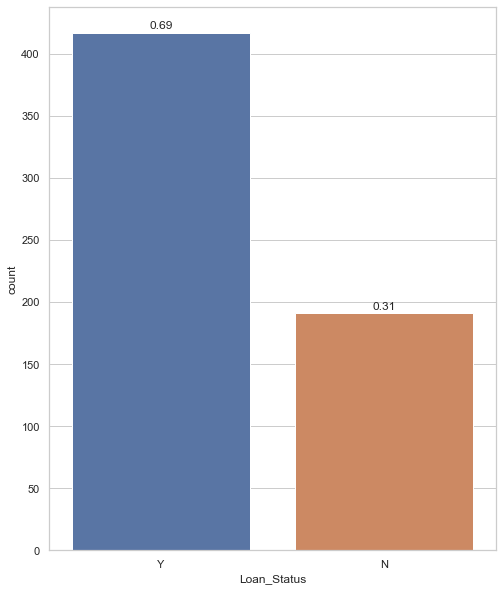

In [22]:
print(tr_df[cat[-1]].value_counts())
#tr_df[cat[-1]].hist(grid = False)

#print(i)
total = float(len(tr_df[cat[-1]]))
plt.figure(figsize=(8,10))
sns.set(style="whitegrid")
ax = sns.countplot(tr_df[cat[-1]])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.2f}'.format(height/total),ha="center") 
plt.show()

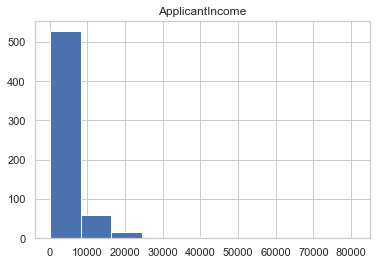

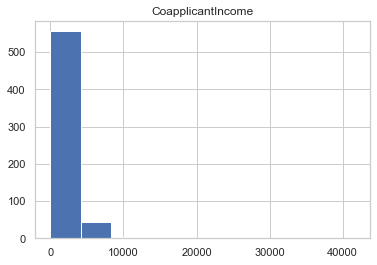

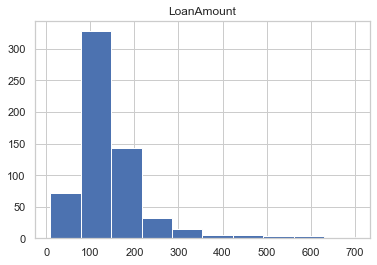

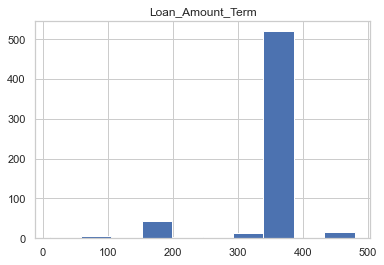

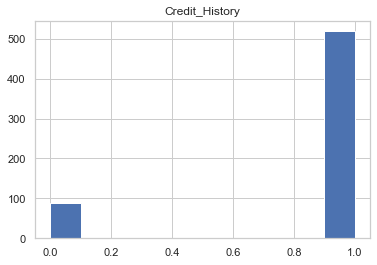

In [23]:
for i in loan_num:
    plt.hist(loan_num[i])
    plt.title(i)
    plt.show()

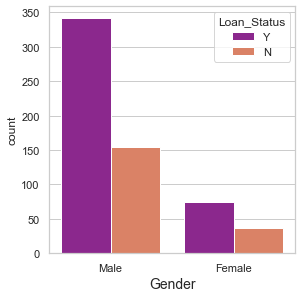

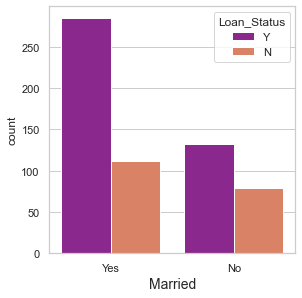

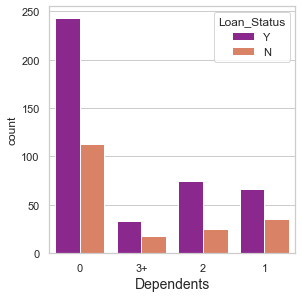

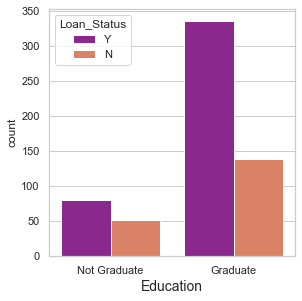

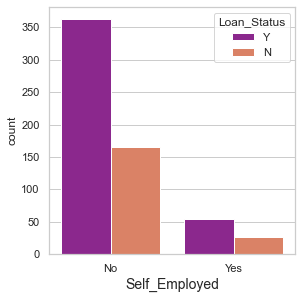

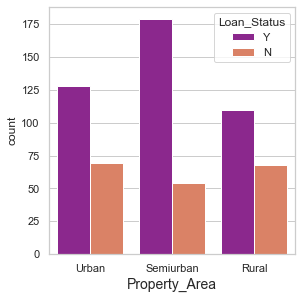

In [24]:
for i in cat[:-1]: 
    plt.figure(figsize=(15,10))
    plt.subplot(2,3,1)
    sns.countplot(x=i ,hue='Loan_Status', data=tr_df ,palette='plasma')
    plt.xlabel(i, fontsize=14)

In [ ]:
#Encoding data to numeric

In [ ]:
#converting categorical values to numbers

to_numeric = {'Male': 1, 'Female': 2,
'Yes': 1, 'No': 2,
'Graduate': 1, 'Not Graduate': 2,
'Urban': 3, 'Semiurban': 2,'Rural': 1,
'Y': 1, 'N': 0,
'3+': 3}

# adding the new numeric values from the to_numeric variable to both datasets
tr_df = tr_df.applymap(lambda lable: to_numeric.get(lable) if lable in to_numeric else lable)
te_df = te_df.applymap(lambda lable: to_numeric.get(lable) if lable in to_numeric else lable)

# convertind the Dependents column
Dependents_ = pd.to_numeric(tr_df.Dependents)
Dependents__ = pd.to_numeric(te_df.Dependents)

# dropping the previous Dependents column
tr_df.drop(['Dependents'], axis = 1, inplace = True)
te_df.drop(['Dependents'], axis = 1, inplace = True)

# concatination of the new Dependents column with both datasets
tr_df = pd.concat([tr_df, Dependents_], axis = 1)
te_df = pd.concat([te_df, Dependents__], axis = 1)

# checking the our manipulated dataset for validation
print(f"training set (row, col): {tr_df.shape}\n\ntesting set (row, col): {te_df.shape}\n")
print(tr_df.info(), "\n\n", te_df.info())

training set (row, col): (608, 12)

testing set (row, col): (367, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608 entries, 0 to 607
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             608 non-null    int64  
 1   Married            608 non-null    int64  
 2   Education          608 non-null    int64  
 3   Self_Employed      608 non-null    int64  
 4   ApplicantIncome    608 non-null    int64  
 5   CoapplicantIncome  608 non-null    float64
 6   LoanAmount         608 non-null    float64
 7   Loan_Amount_Term   608 non-null    float64
 8   Credit_History     608 non-null    float64
 9   Property_Area      608 non-null    int64  
 10  Loan_Status        608 non-null    int64  
 11  Dependents         608 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 57.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 11 column

# Correlation matrix

<AxesSubplot:>

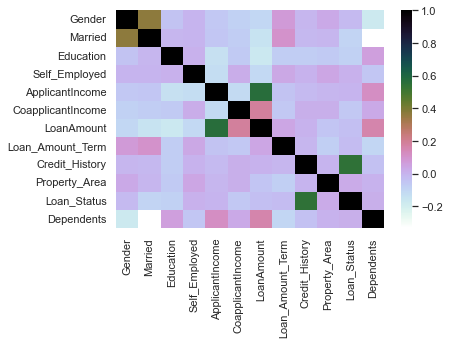

In [26]:
#plotting the correlation matrix
sns.heatmap(tr_df.corr() ,cmap='cubehelix_r')

In [29]:
#correlation table
corr = tr_df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Dependents
Gender,1.00,0.37,-0.05,-0.00,-0.06,-0.08,-0.11,0.08,-0.01,0.03,-0.02,-0.17
Married,0.37,1.00,-0.01,-0.00,-0.05,-0.07,-0.15,0.10,-0.01,-0.01,-0.09,-0.33
Education,-0.05,-0.01,1.00,0.01,-0.14,-0.06,-0.17,-0.07,-0.07,-0.07,-0.09,0.06
Self_Employed,-0.00,-0.00,0.01,1.00,-0.13,0.02,-0.11,0.04,0.00,0.04,0.01,-0.05
ApplicantIncome,-0.06,-0.05,-0.14,-0.13,1.00,-0.12,0.57,-0.05,-0.02,-0.01,-0.00,0.12
CoapplicantIncome,-0.08,-0.07,-0.06,0.02,-0.12,1.00,0.19,-0.06,0.01,0.01,-0.06,0.03
LoanAmount,-0.11,-0.15,-0.17,-0.11,0.57,0.19,1.00,0.04,-0.00,-0.05,-0.03,0.16
Loan_Amount_Term,0.08,0.10,-0.07,0.04,-0.05,-0.06,0.04,1.00,-0.01,-0.08,-0.02,-0.10
Credit_History,-0.01,-0.01,-0.07,0.00,-0.02,0.01,-0.00,-0.01,1.00,-0.00,0.54,-0.04
Property_Area,0.03,-0.01,-0.07,0.04,-0.01,0.01,-0.05,-0.08,-0.00,1.00,0.02,0.00


In [30]:
y = tr_df['Loan_Status']
X = tr_df.drop('Loan_Status', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [31]:
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)

y_predict = DT.predict(X_test)

#  prediction Summary by species
print(classification_report(y_test, y_predict))

# Accuracy score
DT_SC = accuracy_score(y_predict,y_test)
print(f"{round(DT_SC*100,2)}% Accurate")

              precision    recall  f1-score   support

           0       0.47      0.52      0.49        56
           1       0.78      0.74      0.76       127

    accuracy                           0.67       183
   macro avg       0.62      0.63      0.62       183
weighted avg       0.68      0.67      0.68       183

67.21% Accurate


In [ ]:
Decision_Tree=pd.DataFrame({'y_test':y_test,'prediction':y_predict})
Decision_Tree.to_csv("Dection Tree.csv") 

In [32]:
RF = RandomForestClassifier()
RF.fit(X_train, y_train)

y_predict = RF.predict(X_test)

#  prediction Summary by species
print(classification_report(y_test, y_predict))

# Accuracy score
RF_SC = accuracy_score(y_predict,y_test)
print(f"{round(RF_SC*100,2)}% Accurate")

              precision    recall  f1-score   support

           0       0.82      0.50      0.62        56
           1       0.81      0.95      0.88       127

    accuracy                           0.81       183
   macro avg       0.82      0.73      0.75       183
weighted avg       0.82      0.81      0.80       183

81.42% Accurate


In [ ]:
Random_Forest=pd.DataFrame({'y_test':y_test,'prediction':y_predict})
Random_Forest.to_csv("Random Forest.csv") 

In [33]:
XGB = XGBClassifier()
XGB.fit(X_train, y_train)

y_predict = XGB.predict(X_test)

#  prediction Summary by species
print(classification_report(y_test, y_predict))

# Accuracy score
XGB_SC = accuracy_score(y_predict,y_test)
print(f"{round(XGB_SC*100,2)}% Accurate")

[15:11:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.68      0.54      0.60        56
           1       0.81      0.89      0.85       127

    accuracy                           0.78       183
   macro avg       0.75      0.71      0.72       183
weighted avg       0.77      0.78      0.77       183

78.14% Accurate


In [ ]:
XGBoost=pd.DataFrame({'y_test':y_test,'prediction':y_predict})
XGBoost.to_csv("XGBoost.csv")    

In [34]:
LR = LogisticRegression()
LR.fit(X_train, y_train)

y_predict = LR.predict(X_test)

#  prediction Summary by species
print(classification_report(y_test, y_predict))

# Accuracy score
LR_SC = accuracy_score(y_predict,y_test)
print('accuracy is',accuracy_score(y_predict,y_test))

              precision    recall  f1-score   support

           0       0.96      0.41      0.57        56
           1       0.79      0.99      0.88       127

    accuracy                           0.81       183
   macro avg       0.88      0.70      0.73       183
weighted avg       0.84      0.81      0.79       183

accuracy is 0.8142076502732241


In [35]:
score = [DT_SC,RF_SC,XGB_SC,LR_SC]
Models = pd.DataFrame({
    'n_neighbors': ["Decision Tree","Random Forest","XGBoost", "Logistic Regression"],
    'Score': score})
Models.sort_values(by='Score', ascending=False)

,n_neighbors,Score
1,Random Forest,0.814208
3,Logistic Regression,0.814208
2,XGBoost,0.781421
0,Decision Tree,0.672131


In [1]:
import mlflow

ModuleNotFoundError: No module named 'mlflow'